# Data analysis of LexTALE dataset

In [2]:
# import all necessary modules
import pandas as pd
import os
import re
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [5]:
# read in all participant files
files = os.listdir()
ind = 1
for file in files:
    if file.endswith(".csv"):
        print(f'reading {file} now')
        reg_exp = re.compile('_\d\d')
        ppnr = file.split('_')[0]
        if ind ==1:
            data = pd.read_csv(file)
            data['Pp']= ppnr
        else:
            dummy = pd.read_csv(file)
            data = pd.concat([data,dummy], sort=True)
            data.Pp.iloc[-60:] = ppnr
        ind +=1

reading 6_data_LexTALE.csv now
reading 2_data_LexTALE.csv now
reading 5_data_LexTALE.csv now
reading 1_data_LexTALE.csv now


In [43]:
# check the data
data.head()
#data.describe()

,error,response,rt,trial_nr,wordstatus
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,0.170833,0.662500,0.792641,30.500000,0.666667
std,0.377150,0.473845,0.599202,17.354295,0.472390
min,0.000000,0.000000,0.228994,1.000000,0.000000
25%,0.000000,0.000000,0.472843,15.750000,0.000000
50%,0.000000,1.000000,0.617640,30.500000,1.000000
75%,0.000000,1.000000,0.841363,45.250000,1.000000
max,1.000000,1.000000,5.069102,60.000000,1.000000


In [34]:
# for each participant, calculate their LexTALE score and print it and save them in a new dataframe
ind = 0
scores = pd.DataFrame()
for participant in data.Pp.unique():
    ind +=1
    ppdata = data[data.Pp == participant]
    score = (((ppdata[(ppdata.wordstatus == 1) & (ppdata.error == 0)].count()/40*100) + (ppdata[(ppdata.wordstatus == 0) & (ppdata.error == 0)].count()/20*100)) / 2).unique()
    scores[ind] = score
    print(f"Participant {participant} has a score of {score[0]}%")
    

Participant 6 has a score of 0.0%
Participant 2 has a score of 0.0%
Participant 5 has a score of 0.0%
Participant 1 has a score of 0.0%


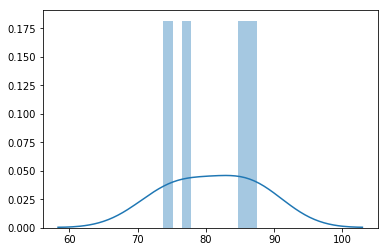

In [10]:
# make a histogram of the scores, makes more sense with more values, but oh well
sns.distplot(scores[:], bins = 10)

In [11]:
# check mean RT for nonwords and words per participant and store them in a new dataframe
cols = ['words', 'nonwords']
lst = []
for participant in data.Pp.unique():
    words = data[(data.Pp == participant) & (data.wordstatus == 1)]
    nonwords = data[(data.Pp == participant) & (data.wordstatus == 0)]
    lst.append([np.mean(words.rt),np.mean(nonwords.rt)])
rtmeans = pd.DataFrame(lst, columns=cols)


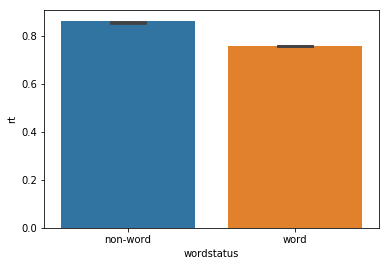

In [63]:
# plot mean RTs for words and non-words, with 95% confidence interval
data.wordstatus = data.wordstatus.replace([0,1], ["non-word","word"])
plot = sns.barplot(x = "wordstatus", y = "rt", ci = .95, capsize=.2, data = data)

In [75]:
Y = data[['wordstatus','trial_nr']]
#data.wordstatus = data.wordstatus.replace(["non-word","word"],[0,1])
# run a GLM to test whether people make more errors for words and nonwords
model = sm.GLM(data.error, Y, family=sm.families.family.Binomial(), groups=data.Pp) 
results = model.fit()
print(results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# run a GLM to test whether people are slower to respond for words than nonwords
modelrt = sm.GLM(data.rt, data.wordstatus, family=sm.families.family.Gaussian(link=sm.families.links.log)) 
resultsrt = modelrt.fit()
print(resultsrt.summary())